# Simple Double Pendulum Using Lagrange's Equation

Defines a LagrangianPendulum class that is used to generate double pendulum plots from solving Lagrange's equations.


## Euler-Lagrange equation

For a double pendulum, the Lagrangian with generalized coordinates $\phi_1$ and $\phi_2$ is

$\begin{align}
  \mathcal{L} = \frac12 (m_1+m_2) L_1^2 \dot\phi_1^2 + \frac12 m_2 L_2^2 \dot\phi_2^2 +  m_2L_1L_2\dot\phi_1\dot\phi_2\cos(\phi_1-\phi_2) + (m_1 + m_2)gL_1\cos\phi_1 + m_2gL_2\cos\phi_2
\end{align}$

The Euler-Lagrange equations are

$\begin{align}
 \frac{d}{dt}\frac{\partial\mathcal{L}}{\partial \dot\phi_1} = \frac{\partial\mathcal L}{\partial\phi_1}
 \quad\Longrightarrow\quad
 \ddot\phi_1 = \frac{m_2g\sin\phi_2\cos(\phi_1-\phi_2) - m_2\sin(\phi_1 - \phi_2)(L_1\dot\phi_1^2\cos(\phi_1 - \phi_2) + L_2\dot\phi_2^2) - (m_1 + m_2)g\sin\phi_1}{L_1(m_1 + m_2\sin^2(\phi_1 - \phi_2)} \\
 \frac{d}{dt}\frac{\partial\mathcal{L}}{\partial \dot\phi_2} = \frac{\partial\mathcal L}{\partial\phi_2}
 \quad\Longrightarrow\quad
 \ddot\phi_2 = \frac{(m_1 + m_2)(L_1\dot\phi_1^2\sin(\phi_1-\phi_2) - g\sin\phi_2 + g\sin\phi_1\cos(\phi_1 - \phi_2)) + m_2L_2\dot\phi_2^2\sin(\phi_1 - \phi_2)\cos(\phi_1 - \phi_2)}{L_2(m_1 + m_2\sin^2(\phi_1 - \phi_2))}
\end{align}$


In [1]:
%matplotlib inline

In [2]:
import numpy as np
from scipy.integrate import odeint, solve_ivp

import matplotlib.pyplot as plt

In [3]:
# The dpi (dots-per-inch) setting will affect the resolution and how large
#  the plots appear on screen and printed.  So you may want/need to adjust 
#  the figsize when creating the figure.
plt.rcParams['figure.dpi'] = 100.    # this is the default for notebook

# Change the common font size (smaller when higher dpi)
font_size = 12
plt.rcParams.update({'font.size': font_size})

## Pendulum class and utility functions

In [4]:
class LagrangianPendulum():
    """
    Pendulum class implements the parameters and Lagrange's equations for 
     a simple double pendulum (no driving or damping).
     
    Parameters
    ----------
    L1 : float
        length of the first pendulum
    L2 : float
        length of the second pendulum
    g : float
        gravitational acceleration at the earth's surface
    m1 : float
        mass of pendulum bob 1
    m2 : float
        mass of pendulum bob 2

    Methods
    -------
    dy_dt(t, y)
        Returns the right side of the differential equation in vector y, 
        given time t and the corresponding value of y.
    """
    def __init__(self, L1=1., L2=1., mass1=1., mass2=1., g=1.
                ):
        self.L1 = L1
        self.L2 = L2
        self.g = g
        self.mass1 = mass1
        self.mass2 = mass2
    
    def dy_dt(self, t, y):
        """
        This function returns the right-hand side of the diffeq: 
        [dphi/dt d^2phi/dt^2]
        
        Parameters
        ----------
        t : float
            time 
        y : float
            A 4-component vector with 
            y[0] = phi1 and y[1] = phi1_dot
            y[2] = phi2 and y[3] = phi2_dot
            
        Returns
        -------
        
        """
        phi1, z1, phi2, z2 = y
        
        c, s = np.cos(phi1 - phi2), np.sin(phi1 - phi2)
        denom = (self.mass1 + self.mass2 * s**2)
        
        phi1_dot = z1
        z1_dot = (self.mass2 * self.g * np.sin(phi2) * c \
                    - self.mass2 * s * (self.L1 * z1**2 * c + self.L2 * z2**2) \
                    - (self.mass1 + self.mass2) * self.g * np.sin(phi1)) \
                    / self.L1 / denom
                  
        phi2_dot = z2
        z2_dot = ((self.mass1 + self.mass2) * (self.L1 * z1**2 * s \
                    - self.g * np.sin(phi2) + self.g * np.sin(phi1) * c)
                    + self.mass2 * self.L2 * z2**2 * s * c) \
                    / self.L2 / denom
        
        return phi1_dot, z1_dot, phi2_dot, z2_dot
    
    def solve_ode(self, t_pts, phi1_0, phi1_dot_0, phi2_0, phi2_dot_0,
                  abserr=1.0e-9, relerr=1.0e-9):
        """
        Solve the ODE given initial conditions.
        Specify smaller abserr and relerr to get more precision.
        """
        y = [phi1_0, phi1_dot_0, phi2_0, phi2_dot_0] 
        solution = solve_ivp(self.dy_dt, (t_pts[0], t_pts[-1]), 
                             y, t_eval=t_pts, 
                             atol=abserr, rtol=relerr)
        phi1, phi1_dot, phi2, phi2_dot = solution.y

        return phi1, phi1_dot, phi2, phi2_dot
    
    def calc_E(y):
        """Total energy of the system"""
            
        th1, th1d, th2, th2d = y.T
        V = -(m1+m2)*L1*g*np.cos(th1) - m2*L2*g*np.cos(th2)
        T = 0.5*m1*(L1*th1d)**2 + 0.5*m2*((L1*th1d)**2 + (L2*th2d)**2 + 2*L1*L2*th1d*th2d*np.cos(th1-th2))
        return T + V


In [5]:
def plot_y_vs_x(x, y, axis_labels=None, label=None, title=None, 
                color=None, linestyle=None, semilogy=False, loglog=False,
                ax=None):
    """
    Generic plotting function: return a figure axis with a plot of y vs. x,
    with line color and style, title, axis labels, and line label
    """
    if ax is None:        # if the axis object doesn't exist, make one
        ax = plt.gca()

    if (semilogy):
        line, = ax.semilogy(x, y, label=label, 
                            color=color, linestyle=linestyle)
    elif (loglog):
        line, = ax.loglog(x, y, label=label, 
                          color=color, linestyle=linestyle)
    else:
        line, = ax.plot(x, y, label=label, 
                    color=color, linestyle=linestyle)

    if label is not None:    # if a label if passed, show the legend
        ax.legend()
    if title is not None:    # set a title if one if passed
        ax.set_title(title)
    if axis_labels is not None:  # set x-axis and y-axis labels if passed  
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    return ax, line

In [6]:
def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

## Make simple double pendulum plots 

In [7]:
# Labels for individual plot axes
phi_vs_time_labels = (r'$t$', r'$\phi(t)$')
phi_dot_vs_time_labels = (r'$t$', r'$d\phi/dt(t)$')
state_space_labels = (r'$\phi$', r'$d\phi/dt$')

# Common plotting time (generate the full time then use slices)
t_start = 0.
t_end = 50.
delta_t = 0.001

# creating time vector
t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

L1 = 1.
L2 = 1.
g = 1.
mass1 = 1.
mass2 = 1.

# Instantiate a pendulum 
p1 = LagrangianPendulum(L1=L1, L2=L2, mass1=mass1, mass2=mass2, g=g)

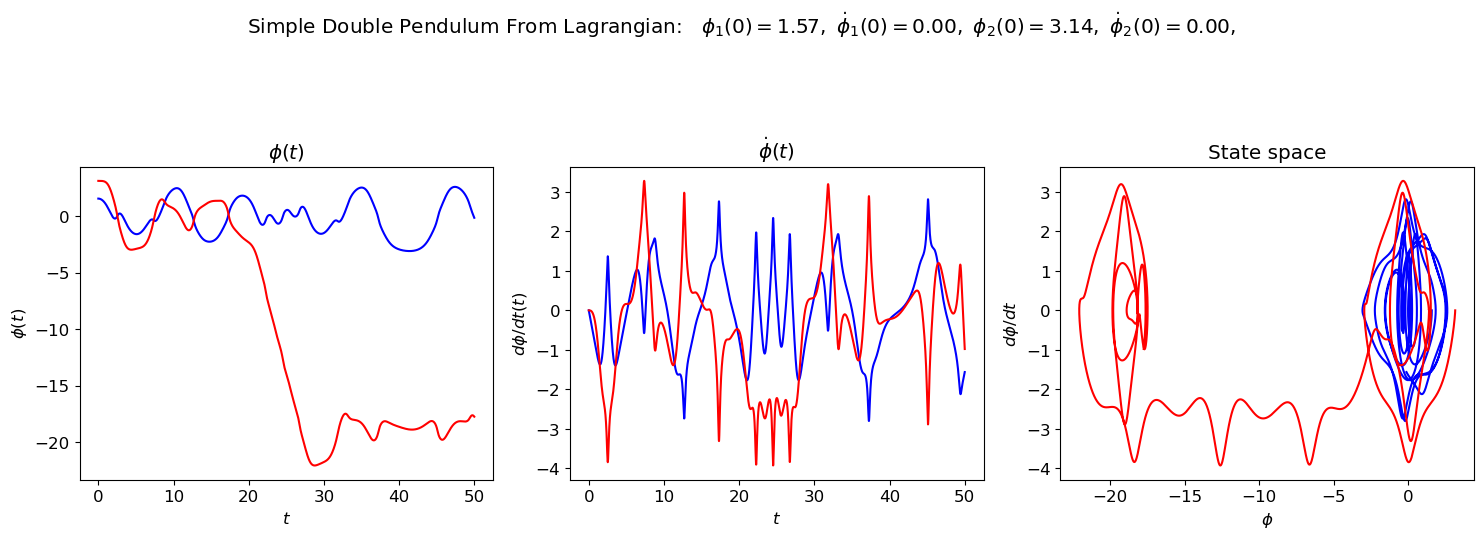

In [8]:
# setting initial conditions for the subsequent plots
phi1_0 = np.pi/2.
phi1_dot_0 = 0.
phi2_0 = np.pi
phi2_dot_0 = 0.

# solving for the two angles and angular velocities with an ode solver

phi1, phi1_dot, phi2, phi2_dot = p1.solve_ode(t_pts, phi1_0, phi1_dot_0, phi2_0, phi2_dot_0)

# start the plot!
fig = plt.figure(figsize=(15,5))
overall_title = 'Simple Double Pendulum From Lagrangian:  ' + \
                rf' $\phi_1(0) = {phi1_0:.2f},$' + \
                rf' $\dot\phi_1(0) = {phi1_dot_0:.2f},$' + \
                rf' $\phi_2(0) = {phi2_0:.2f},$' + \
                rf' $\dot\phi_2(0) = {phi2_dot_0:.2f},$' + \
                '\n'     # \n means a new line (adds some space here)
fig.suptitle(overall_title, va='baseline')
    
# first plot: phi plot 
ax_a = fig.add_subplot(1,3,1)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start : stop], phi1[start : stop], 
            axis_labels=phi_vs_time_labels, 
            color='blue',
            label=None, 
            title=r'$\phi(t)$', 
            ax=ax_a) 
plot_y_vs_x(t_pts[start : stop], phi2[start : stop], 
            axis_labels=phi_vs_time_labels, 
            color='red',
            label=None, 
            title=r'$\phi(t)$', 
            ax=ax_a)
                              
# # second plot: phi_dot plot 
ax_b = fig.add_subplot(1,3,2)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start : stop], phi1_dot[start : stop], 
            axis_labels=phi_dot_vs_time_labels, 
            color='blue',
            label=None, 
            title=r'$\dot\phi(t)$', 
            ax=ax_b)   
plot_y_vs_x(t_pts[start : stop], phi2_dot[start : stop], 
            axis_labels=phi_dot_vs_time_labels, 
            color='red',
            label=None, 
            title=r'$\dot\phi(t)$', 
            ax=ax_b) 

# third plot: state space plot from t=0 to t=50   
ax_c = fig.add_subplot(1,3,3)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(phi1[start : stop], phi1_dot[start : stop], 
            axis_labels=state_space_labels, 
            color='blue',
            label=None, 
            title='State space', 
            ax=ax_c)   
plot_y_vs_x(phi2[start : stop], phi2_dot[start : stop], 
            axis_labels=state_space_labels, 
            color='red',
            label=None, 
            title='State space', 
            ax=ax_c)

fig.tight_layout()
fig.savefig('simple_double_pendulum_Lagrange.png', bbox_inches='tight')  

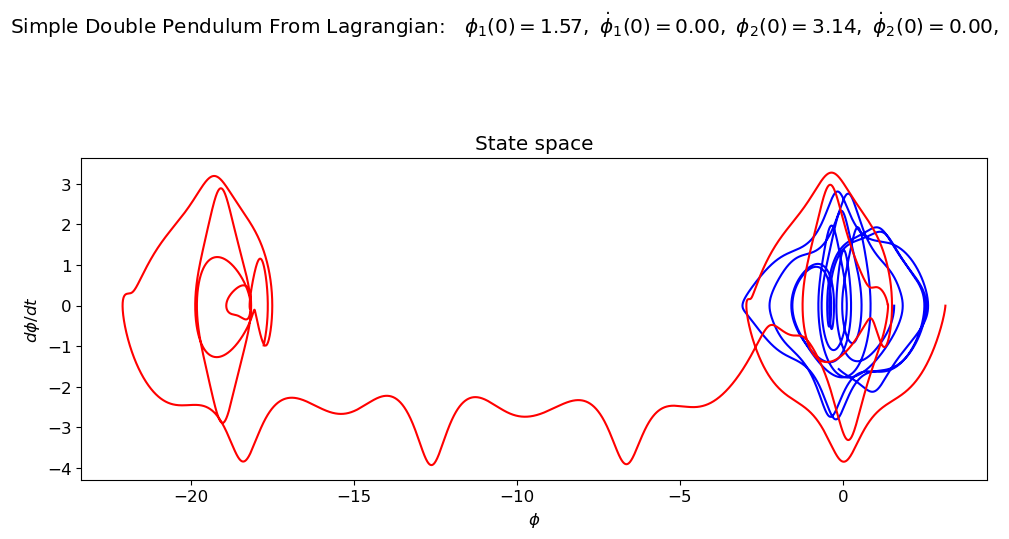

In [9]:
# solving for the two angles and angular velocities with an ode solver

phi1, phi1_dot, phi2, phi2_dot = p1.solve_ode(t_pts, phi1_0, phi1_dot_0, phi2_0, phi2_dot_0)

# start the plot!
fig = plt.figure(figsize=(10,5))
overall_title = 'Simple Double Pendulum From Lagrangian:  ' + \
                rf' $\phi_1(0) = {phi1_0:.2f},$' + \
                rf' $\dot\phi_1(0) = {phi1_dot_0:.2f},$' + \
                rf' $\phi_2(0) = {phi2_0:.2f},$' + \
                rf' $\dot\phi_2(0) = {phi2_dot_0:.2f},$' + \
                '\n'     # \n means a new line (adds some space here)
fig.suptitle(overall_title, va='baseline')

# third plot: state space plot from t=0 to t=100 
ax_e = fig.add_subplot(1,1,1)                  

start, stop = start_stop_indices(t_pts, t_start, 2*t_end)    
plot_y_vs_x(phi1[start : stop], phi1_dot[start : stop], 
            axis_labels=state_space_labels, 
            color='blue',
            label=None, 
            title='State space', 
            ax=ax_e)   
plot_y_vs_x(phi2[start : stop], phi2_dot[start : stop], 
            axis_labels=state_space_labels, 
            color='red',
            label=None, 
            title='State space', 
            ax=ax_e)

fig.tight_layout()
fig.savefig('Extended_state_space.png', bbox_inches='tight') 

Now trying the power spectrum, plotting only positive frequencies and cutting off the lower peaks:

In [10]:
# start, stop = start_stop_indices(t_pts, t_start, t_end)    
# signal = phi1[start:stop]
# power_spectrum = np.abs(np.fft.fft(signal))**2
# freqs = np.fft.fftfreq(signal.size, delta_t)
# idx = np.argsort(freqs)

# fig_ps = plt.figure(figsize=(5,5))
# ax_ps = fig_ps.add_subplot(1,1,1)
# ax_ps.semilogy(freqs[idx], power_spectrum[idx], color='blue')
# ax_ps.set_xlim(0, 1.)
# ax_ps.set_ylim(1.e5, 1.e11)
# ax_ps.set_xlabel('frequency')
# ax_ps.set_title('Power Spectrum')

# fig_ps.tight_layout()
# fig.savefig('sdp_power_spectrum.png', bbox_inches='tight') 

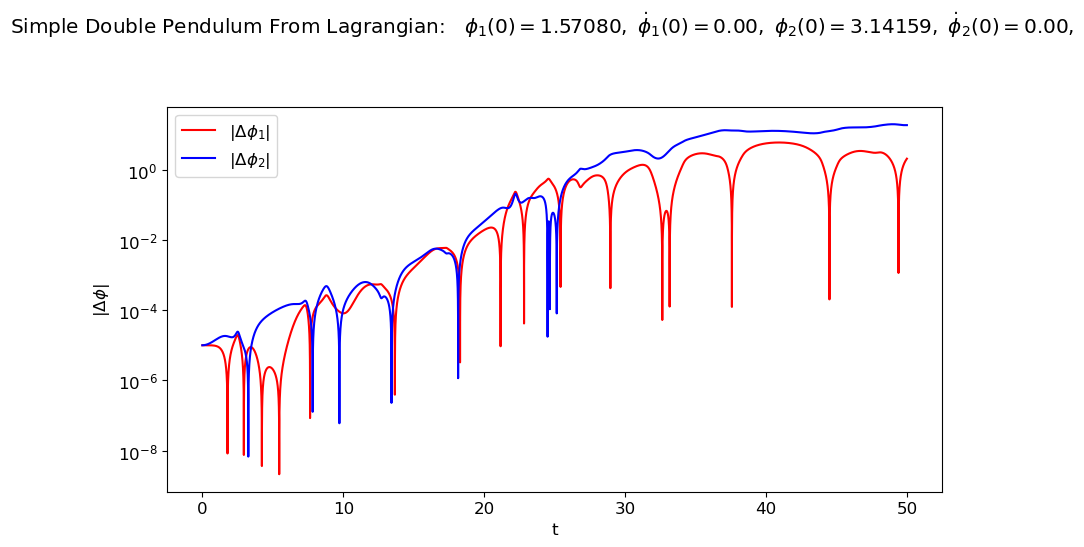

In [11]:
# solving for the two angles and angular velocities with an ode solver
phi1_1, phi1_dot, phi2_1, phi2_dot = p1.solve_ode(t_pts, phi1_0, phi1_dot_0, phi2_0, phi2_dot_0)
phi1_2, phi1_dot, phi2_2, phi2_dot = p1.solve_ode(t_pts, phi1_0+0.00001, phi1_dot_0, phi2_0+0.00001, phi2_dot_0)

#subtracting the the phi's and using the difference to plot from t=0 to t=50
Delta_phi1 = np.fabs(phi1_2 - phi1_1)
Delta_phi2 = np.fabs(phi2_2 - phi2_1)

# creating the title for the plot
fig = plt.figure(figsize=(10,5))
overall_title = 'Simple Double Pendulum From Lagrangian:  ' + \
                rf' $\phi_1(0) = {phi1_0:.5f},$' + \
                rf' $\dot\phi_1(0) = {phi1_dot_0:.2f},$' + \
                rf' $\phi_2(0) = {phi2_0:.5f},$' + \
                rf' $\dot\phi_2(0) = {phi2_dot_0:.2f},$' + \
                '\n'     # \n means a new line (adds some space here)
fig.suptitle(overall_title, va='baseline')

#creating the figure named ax_d
ax_d = fig.add_subplot(1,1,1)                  

#semilog plot with t for the x-axis and delta phi as the y axis from 0 to 50. Plotting the difference of phi's for the first pendulum and the second pendulum
start, stop = start_stop_indices(t_pts, t_start, t_end)
ax_d.semilogy(t_pts[start : stop], Delta_phi1[start : stop], 
            color='red', label=None)    
start, stop = start_stop_indices(t_pts, t_start, t_end)
ax_d.semilogy(t_pts[start : stop], Delta_phi2[start : stop], 
            color='blue', label=None)    
ax_d.set_xlabel('t')
ax_d.set_ylabel(r'$|\Delta\phi|$')
ax_d.legend([r'$|\Delta\phi_1|$',r'$|\Delta\phi_2|$'])

fig.savefig('sdp_chaos_proof.png', bbox_inches='tight')  

In [12]:
from matplotlib import animation, rc
from IPython.display import HTML

In [13]:
def xy_coords(x0, y0, phi, L):
    """convert angle and pendulum length to x,y position
    """
    x = x0 + L * np.sin(phi)
    y = y0 - L * np.cos(phi)
    return x, y

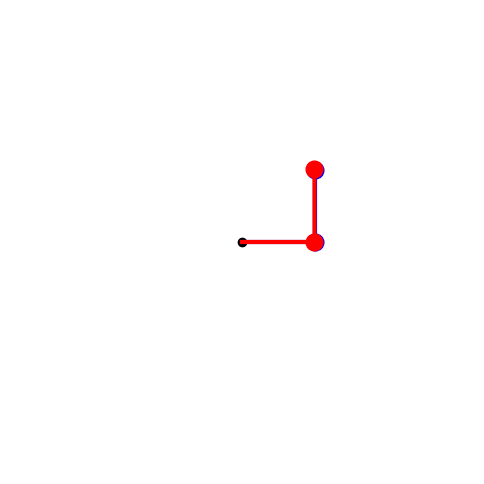

In [14]:
# Animate the double pendulum
# %%capture
x_min = -3.2
x_max = -x_min
y_min = -3.2
y_max = -y_min

# Common plotting time (generate the full time then use slices)
t_start = 0.
t_end = 100.
delta_t = 0.001

# creating time vector
t_pts = np.arange(t_start, t_end+delta_t, delta_t) 

fig_anim = plt.figure(figsize=(5,5), num='Simple Double Pendulum')
ax_anim = fig_anim.add_subplot(1,1,1)
ax_anim.set_xlim(x_min, x_max)
ax_anim.set_ylim(y_min, y_max)

# By assigning the first return from plot to line_anim, we can later change
#  the values in the line.
x0, y0 = 0., 0.
pt0_anim, = ax_anim.plot(x0, y0, 'o', markersize=6, color='black')
x1, y1, = xy_coords(x0, y0, phi1_1[0], p1.L1)
pt1_anim, = ax_anim.plot(x1, y1, 'o', markersize=12, color='blue')
ln1_anim, = ax_anim.plot([x0, x1], [y0, y1], color='blue', lw=3)
x2, y2 = xy_coords(x1, y1, phi2_1[0], p1.L2)
pt2_anim, = ax_anim.plot(x2, y2, 'o', markersize=12, color='blue')
ln2_anim, = ax_anim.plot([x1, x2], [y1, y2], color='blue', lw=3)

x1b, y1b = xy_coords(x0, y0, phi1_2[0], p1.L1)
pt1b_anim, = ax_anim.plot(x1b, y1b, 'o', markersize=12, color='red')
ln1b_anim, = ax_anim.plot([x0, x1b], [y0, y1b], color='red', lw=3)
x2b, y2b = xy_coords(x1b, y1b, phi2_2[0], p1.L2)
pt2b_anim, = ax_anim.plot(x2b, y2b, 'o', markersize=12, color='red')
ln2b_anim, = ax_anim.plot([x1b, x2b], [y1b, y2b], color='red', lw=3)

ax_anim.set_aspect(1)
ax_anim.axis('off')
fig_anim.tight_layout()

In [15]:
def animate_dpendulum(i):
    """This is the function called by FuncAnimation to create each frame,
        numbered by i.  So each i corresponds to a point in the t_pts
        array, with index i.
    """
    i_skip = 50 * i
    
    x0, y0 = 0., 0.
    pt0_anim.set_data(x0, y0)
    
    x1, y1 = xy_coords(x0, y0, phi1_1[i_skip], p1.L1)
    pt1_anim.set_data(x1,y1)
    ln1_anim.set_data([x0, x1], [y0, y1])
    x2, y2 = xy_coords(x1, y1, phi2_1[i_skip], p1.L2)
    pt2_anim.set_data(x2,y2)
    ln2_anim.set_data([x1, x2], [y1, y2])
    
    x1b, y1b = xy_coords(x0, y0, phi1_2[i_skip], p1.L1)
    pt1b_anim.set_data(x1b,y1b)
    ln1b_anim.set_data([x0, x1b], [y0, y1b])
    x2b, y2b = xy_coords(x1b, y1b, phi2_2[i_skip], p1.L2)
    pt2b_anim.set_data(x2b,y2b)
    ln2b_anim.set_data([x1b, x2b], [y1b, y2b])
    
    return (pt0_anim, pt1_anim, ln1_anim, pt2_anim, ln2_anim, pt1b_anim, ln1b_anim, pt2b_anim, ln2b_anim)

In [16]:
frame_interval = 1.  # time between frames
frame_number = 1000    # number of frames to include (index of t_pts)
anim = animation.FuncAnimation(fig_anim, 
                               animate_dpendulum, 
                               init_func=None,
                               frames=frame_number, 
                               interval=frame_interval, 
                               blit=True,
                               repeat=False)

In [ ]:
HTML(anim.to_jshtml())